# Detection and dealing with bias in EHR data

Biases in Electronic Health Records (EHR) data pose significant challenges to healthcare analytics, potentially leading to skewed research findings and clinical decision-making.
These biases can arise from various sources, such as selective documentation, patient demographic skews, or algorithmic biases in data collection and processing.
Such biases can result in the misrepresentation of patient populations, the underrepresentation of minority groups, or inaccuracies in disease prevalence rates.
Exploratory data analysis (EDA), through data visualization, statistical summaries, and pattern identification, is a critical step in uncovering and mitigating biases.

In this tutorial, we outline the various sources of bias, show how they can be detected and potentially mitigated with ehrapy.
It is important to note that many biases are already inherent to the data collection process itself and can only be unveiled but not always dealth with.
We make use of the [Diabetes 130-US Hospitals for years 1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) dataset and a synthetic dataset for our analysis. ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/))

Modeling of biases and health requires comprehensive data covering a large spectrum of patient characteristics such as different diagnoses: here, we focus on the publicly available dataset which covers only patients of a diabetic diagnosis ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

We reproduce parts of the tutorial Fairness in AI systems: From social context to practice using Fairlearn by Manojit Nandi, Miroslav Dudík, Triveni Gandhi, Lisa Ibañez, Adrin Jalali, Michael Madaio, Hanna Wallach, Hilde Weerts (CC BY 4.0 License), which builds upon the [fairlearn toolkit](https://fairlearn.org/), and extend insights by using ehrapy functionality. This toolkit integrates well with ehrapy, and offers extensive, well-documented functionality regarding fairness in AI systems. This is provides an excellent combination for powering exploratory data analysis in Electronic Health Record Data and candidates for modelling.

In [10]:
import ehrapy as ep
import fairlearn
import seaborn as sns
from tableone import TableOne
import pandas as pd
import numpy as np

from fairlearn.datasets import fetch_diabetes_hospital

In [11]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

In [3]:
# !pip install fairlearn

### Introduction to Dataset

|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |

In [190]:
df = fetch_diabetes_hospital().data

In [191]:
df.shape

In [4]:
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["race", "gender", "age"], copy_obs=True)

2024-03-19 14:01:44,679 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `101766` x `24`.
2024-03-19 14:01:44,710 - root INFO - Added `['race', 'gender', 'age']` to `obs`.


AnnData object with n_obs × n_vars = 101766 × 24
    obs: 'race', 'gender', 'age'
    var: 'ehrapy_column_type'
    layers: 'original'

In [5]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in adata.var_names:
    if col not in {
        "time_in_hospital",
        "num_lab_procedures",
        "num_procedures",
        "num_medications",
        "number_diagnoses",
    }:
        categorical_values[col] = pd.Series(
            pd.Series(adata.X[:, adata.var_names == col][:, 0])
            .value_counts()
            .index.values
        )
categorical_values_df = pd.DataFrame(categorical_values).fillna("")
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,'Over 60 years','30-60 years','30 years or younger',,,
discharge_disposition_id,'Discharged to Home',Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,'Respiratory Issues',Diabetes,'Genitourinary Issues','Musculoskeletal Issues',
max_glu_serum,Norm,>200,>300,,,
A1Cresult,>8,Norm,>7,,,
insulin,No,Steady,Down,Up,,


## Selection bias

Selection bias occurs when the data are not representative of the general population, often because the individuals in the dataset are more likely to seek care or have certain conditions.
This can lead to skewed results and incorrect inferences about disease prevalence, treatment effects, or health outcomes.
For example, a study using EHR data from a specialized clinic may overestimate the prevalence of a specific condition because patients visiting the clinic are more likely to have that condition compared to the general population.

The facettes of the data selection, and hence sources of biases, are diverse and occur at different stages:

a) "Raw Data": The most unprocessed form of the public dataset available represents a strongly subsampled set of observations already. It is restricted to a set of hospitals, to a geographic region, and patients which have visited these hospitals. In order to make the data accessible, this data has been filtered and processed described in ([Strack et al. 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).
This is important to keep in mind when attempting to generalize the results to other settings.

b) We consider the further processed and aggregated dataset from Fairlearn, see [here](https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py) for preprocessing details.

c) This dataset is per-patient-visit, not a per-patient basis: beware that the same patient may be included mulitple times

### Example: Patient Demographics
Here, we show how patient demographics are represented in the dataset.
A popular option in clinical studies is by representing this information in a table:

In [6]:
TableOne(adata.obs)

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

ehrapy allows to represent this information graphically as well:

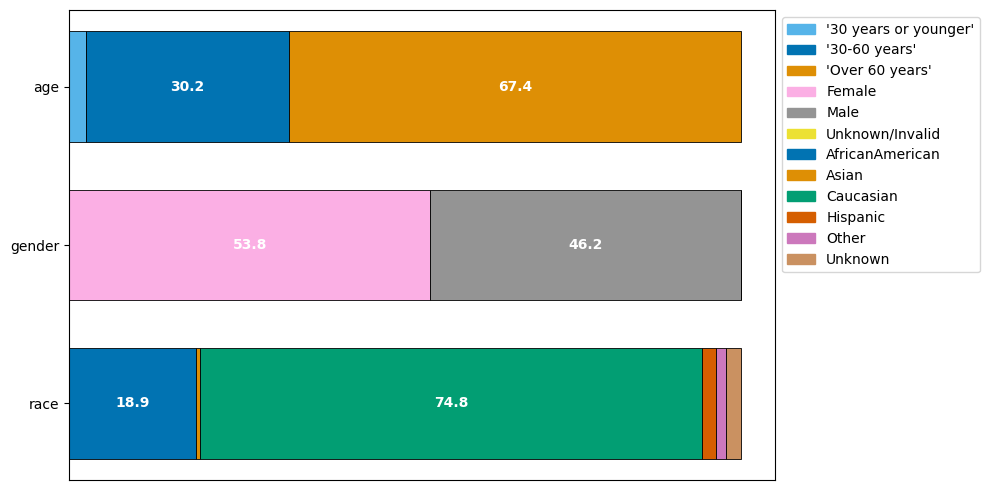

In [7]:
ct = ep.tl.CohortTracker(adata)
ct(adata)
ct.plot_cohort_barplot()

We can observe immediately how the different demographics are represented:
- The age group "Over 60 years" is represented more often than the others.
- The gender seems to be balanced between male and female, with females forming a slight majority in the dataset.
- The race shows how Caucasian is the most frequent in the dataset. While African American contributes a significant part of the dataset, Asian, Hispanic, Other and Unknown alltogether form less than 7% of the data.

#### Mitigation strategies addressing small group sizes
- collect more data
    - Pro: The first choice whenever possible, improving coverage
    - Con: Expensive, time-consuming, maybe not feasible
- merge small groups
    - Pro: Information across groups shared
    - Con: Can mask differences between groups
- drop smaller groups
    - Pro: Methods do not suggest knowledge about underrepresented groups if there is not enough data available to generate such
    - Con: Lack of representation, "[harm of erasure](https://fairlearn.org/main/user_guide/fairness_in_machine_learning.html)"

Here, we will
* merge the three smallest race groups *Asian*, *Hispanic*, *Other* (similar to [Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/))

* drop the gender group *Unknown/Invalid*, because the sample size is so small that no meaningful assessment is possible

In [8]:
# TODO: maybe at a later stage if want to include bias things below?

#### Further analyses options
To get deeper understanding of the represented population, this data could be compared to the demographics at the geographic region under observation, at the time of the recording.

## Filtering bias

Filtering bias emerges when the criteria used to include or exclude records in the analysis are not clearly defined or are applied inconsistently, potentially leading to a non-representative sample of the original population.
This bias can obscure the true relationships between variables by systematically removing certain patient groups or information based on arbitrary or non-transparent criteria.
For instance, if multiple filtering steps are conducted to clean the data or select specific cohorts without adequately documenting the reasons or thresholds for these decisions, it may be difficult to replicate the study or assess the validity of its findings, thus compromising the reliability of the conclusions drawn.

Consider below an example where one filters to the subgroup of *[Medicare](https://www.hhs.gov/answers/medicare-and-medicaid/what-is-the-difference-between-medicare-medicaid/index.html)* recipients.
In the United States, *Medicare* is a joint federal and state program to help qualified individuals pay for healthcare expenses. *Medicare* is available to people over the age of 65 and younger individuals with severe illnesses.

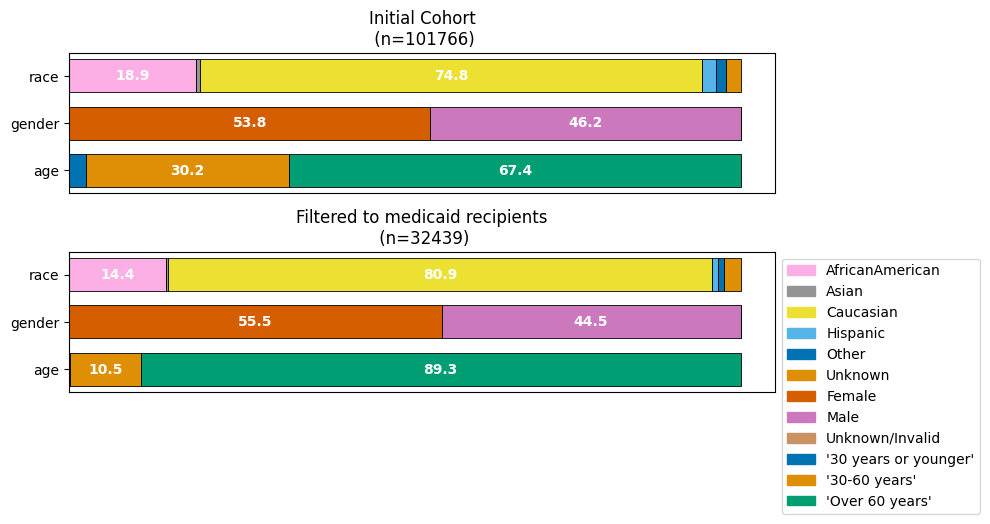

In [9]:
adata_filtered = adata.copy()
ct = ep.tl.CohortTracker(adata_filtered, columns=["age", "gender", "race"])
ct(adata_filtered, label="Initial Cohort")
# ct.plot_cohort_barplot()

adata_filtered = adata_filtered[
    adata_filtered.X[:, adata_filtered.var_names == "medicare"] == True
]
ct(adata_filtered, label="Filtered to medicaid recipients")
ct.plot_cohort_barplot(subfigure_title=True)

ehrapy allows for a visual tracking of key variables of interest in our dataset, here we select our demographic variables.

While we would expect that our medicare-recipients filtered dataset will consist predominantly of patients over 60 years, we might not have expected that the imbalance of the different reported race groups is aggraveted.

### Mitigation strategies
- Carefully evaluate the filtering strategies
- Monitor key variables of patient population representation in the dataset

### Further analyses options
With the filtering steps being crucial to any analysis performed, assessing the sensitivity of the modelling process to e.g. different filtering thresholds can be insightful.

## Surveillance bias

Surveillance bias occurs when the likelihood of detecting a condition or outcome is influenced by the intensity or frequency of monitoring, leading to an overestimation of the association between exposure and outcome.
This bias is particularly prevalent in studies where certain groups are more closely observed than others, resulting in a higher detection rate of conditions in these groups regardless of actual prevalence.
For instance, individuals in a clinical trial may receive more rigorous testing and follow-up compared to the general population, thus appearing to have higher rates of certain conditions or side effects.

In [10]:
# from fairlearn.datasets import fetch_diabetes_hospital
# df = fetch_diabetes_hospital(as_frame=True).frame

# df["A1Cresult_measured"] = df["A1Cresult"] != "None"
# sns.catplot(
#     y="A1Cresult_measured",
#     x="admission_source_id",
#     data=df,
#     hue="race",
#     kind="point",
#     ci=95,
#     dodge=True,
#     join=False
# )

In [11]:
# ep.ad.move_to_obs(adata, ["A1Cresult", "admission_source_id"], copy_obs=True)
adata.obs["A1Cresult_measured"] = ~adata.obs["A1Cresult"].isna()

KeyError: 'A1Cresult'

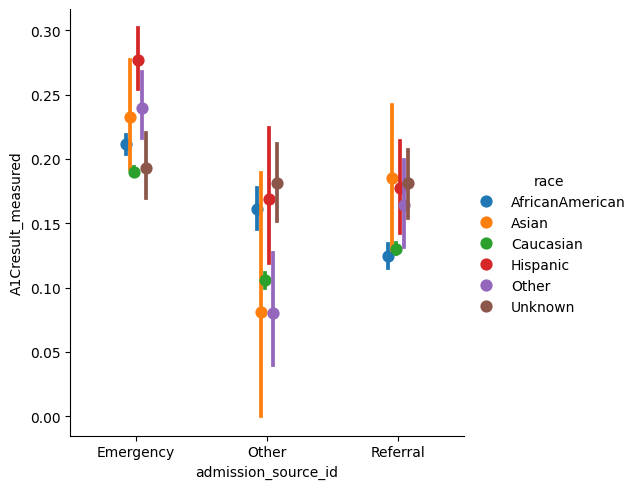

In [ ]:
sns.catplot(
    y="A1Cresult_measured",
    x="admission_source_id",
    data=adata.obs,
    hue="race",
    kind="point",
    ci=95,
    dodge=True,
    join=False,
)

Hemoglobin A1c (HbA1c) is an important measure of glucose control, which is widely applied to measure performance of diabetes care ([Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

Strack et al. highlight that the measurement of HbA1c at the time of hospital admission offers an opportunity to assess the current diabetes therapy efficacy, but is only done in 18.4% of patients in the inpatient setting.

Here, we can observe that differences between the patient admission type seem to exist, across all race subgroups: Namely, it appears to be measured more frequently for emergency admissions than for referrals.

The reasons for the differences in surveillance can be manifold; without further information on the reasons, in this case only speculative guesses are possible.

### Mitigation strategies
- Take particular care when drawing collective conclusions on patients experiencing different surveillance

### Further analyses options
To understand what the reasons for differences in surveillance are, in detailed studies discussing the protocols and clinical practice which is in place, as well as differently surveilled cohorts in the dataset can improve our understanding and the quality of drawn conclusions.

## Missing data bias

Missing data bias refers to the distortion in analysis results caused by non-random absence of data points, which can occur through various types, such as missing completely at random (MCAR), missing at random (MAR), and not missing at random (NMAR).
Each type affects the data and subsequent analyses differently, with MCAR having the least impact since the missingness is unrelated to the study variables or outcomes, whereas MAR and NMAR can introduce significant bias if the reasons for missingness are related to the study variables or if the missingness itself is informative.
For instance, if patients with more severe symptoms are less likely to have complete records (NMAR), analyses may underestimate the severity and impact of certain conditions.

### Example: Measurement of HbA1c
Let us examine the missingness of HbA1c measurements. To say a variable is MCAR means its missingness does not depend on the value of other variables.

For an illustration, let us check whether the missingness of HbA1c measurement is the same across age groups:

In [12]:
adata.obs[["age", "A1Cresult_measured"]].groupby("age").mean().plot(kind="bar")

KeyError: "['A1Cresult_measured'] not in index"

We can immediately see that the missingness of an HbA1c measurement is strongly connected with the age variable: for patients 30 years or younger, the measurement is missing in 36% of cases, for 30-60 years it is missing in 21% of cases, and for patients over 60 years it is missing in only 14% of cases.

Many factors have an impact on a healthcare professional's decision whether to measure a patient's HbA1c level. For the dataset, this means that missing values often are not MCAR, that is, they show dependence on the values of other variables.

This observation can be discussed together with clinical practice to elaborate on reasons on the missingness of these values.
The missingness mechanism does play a role in the analysis particularly when imputing data; 

### Mitigation strategies
- Employ systematic statistical tests for data missingness


In [13]:
# TODO: a test like littles which can do categorical variables, too?

In [ ]:
import pyampute as pa

# check non-random missingness
from pyampute.exploration.mcar_statistical_tests import MCARTest

mc = MCARTest("ttest")

data = np.random.randn(6, 2)
data[0:3, 1] = np.nan
print(data)
df = pd.DataFrame(data)

print(mc.little_mcar_test(df))

In [ ]:
from scipy.stats import ttest_ind

a = data[0:3, 0]
b = data[3:, 0]
ttest_ind(a, b, equal_var=True)

#### Further analyses steps
Discuss potential mechanisms causing data missingness; Apply particular care when doing imputation, and potentially evaluate different imputation methods and compare results.

Little's test on some data where we know what kind of type it should be...? Only working on numerical data is an issue

## Imputation bias

Imputation bias, a more specific form of algorithmic bias, occurs when the process used to estimate and fill in missing values introduces systematic differences between the imputed values and the true values.
This can happen if the imputation method does not accurately reflect the underlying data distribution or the reasons for missingness, leading to skewed analyses and incorrect conclusions.
For example, using mean imputation for missing values in a dataset with a non-normal distribution may artificially reduce variability and lead to misleading inferences about the population characteristics or treatment effects.

In [14]:
# TODO: maybe show together with algorithmic bias how bad imputation can immediately aggravate things..?

Maybe show how the KNN imputation algorithm can introduce some biases in specific setups. Are there other ways to measure uncertainty? We should look into the literature and potentially implement things. Maybe also https://github.com/theislab/ehrapy/issues/652? What about time aware imputation?

## Algorithmic bias

Algorithmic bias occurs when algorithms systematically favor certain groups over others, often due to biases inherent in the data used to train these algorithms.
This can result in unequal treatment recommendations, risk predictions, or health outcomes assessments across different demographics, such as race, gender, or socioeconomic status.
For instance, an algorithm trained predominantly on data from one ethnic group may perform poorly or inaccurately predict outcomes for individuals from underrepresented groups, exacerbating disparities in healthcare access and outcomes.

### Example: Recommending patients for *high-risk care management* programs
Here, we follow an example from the [Fairlearn SciPy 2021 Tutorial:  Fairness in AI Systems](https://github.com/fairlearn/talks/tree/main/2021_scipy_tutorial), in a shortened and slightly modified analysis.

#### The Scenario
When allocating healthcare resources, identifying patients with complex health needs is crucial to provide such patients with additional resources. When algorithms are used to support such decision making, it is of critical importance to assess and guarantee that these algorithms mitigate biases and operate in a fair manner.

Here, we consider the task of predicting **hospital readmission within 30 days** from a dataset of hospital data of diabetic patients. Such a quick readmission is viewed as proxy that the patient needed more assistance at release time: Hence this will be the label that we wish to predict.

We follow the decision in the earlier work to measure the
- balanced accuracy, to investigate the performance of the algorithm
- the selection rate, to investigate how many patients are recommended for care
- the false negative rate, to investigate how many patients are considered would have missed the needed assistance

#### Bias/Fairness Consideration
We want to investigate whether and which patient subgroups of the demographic variable `race` are negatively affected by a model.

#### Mitigation
We explore a toolkit offering algorithmic mitigation methods to account for negatively affected subgroups.

Disclaimer: We consider a small example on real data: while the insight of how potential biases can affect a model is real, the example is too limited in scope and evaluation to be considered a solution to a real world problem.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.metrics import MetricFrame, false_negative_rate, selection_rate
from fairlearn.postprocessing import ThresholdOptimizer

#### Data Preparation
We load the dataset, and put variables we are not interested to pass to our model but into the `.obs` field.
We build a binary label `readmit_30_days` indicating whether a patient has been readmitted in <30 days.

In [15]:
adata_algo = ep.dt.diabetes_130_fairlearn(
    columns_obs_only=[
        "race",
        "gender",
        "age",
        "readmitted",
        "readmit_binary",
        "discharge_disposition_id",
    ]
)
adata_algo.obs["readmit_30_days"] = adata_algo.obs["readmitted"] == "<30"

2024-03-20 16:45:47,787 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `101766` x `18`.


In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.
In this dataset, gender is primarily reported binary, with 54% *Female* and 46% *Male*, and 3 samples annotated as *Unknown/Invalid*

In [16]:
TableOne(adata_algo.obs, columns=["race", "gender", "age"])

Missing       Overall
n                                                  101766
race, n (%)   AfricanAmerican             0  19210 (18.9)
              Asian                             641 (0.6)
              Caucasian                      76099 (74.8)
              Hispanic                         2037 (2.0)
              Other                            1506 (1.5)
              Unknown                          2273 (2.2)
gender, n (%) Female                      0  54708 (53.8)
              Male                           47055 (46.2)
              Unknown/Invalid                     3 (0.0)
age, n (%)    '30 years or younger'       0    2509 (2.5)
              '30-60 years'                  30716 (30.2)
              'Over 60 years'                68541 (67.4)

#### Decision: How to address smaller group sizes?
We have seen different strategies to address smaller group sizes in the selection bias part.

- For the `race` variable, we will follow the strategy of using buckets to merge small groups *Other*, *Spanish*, *Asian*.
- For the `gender` variable, we will remove the *Unknown/Invalid* annotated samples, as no meaningful assessment is possible with this sample size

In [18]:
# aggregate small groups
adata_algo.obs["race_all"] = adata_algo.obs["race"]
adata_algo.obs["race"] = adata_algo.obs["race"].replace(
    {"Asian": "Other", "Hispanic": "Other"}
)

# drop gender group Unknown/Invalid
adata_algo = adata_algo[adata_algo.obs["gender"] != "Unknown/Invalid", :].copy()
ep.ad.move_to_x(adata_algo, "gender")

2024-03-20 16:46:01,175 - root INFO - Added `['gender']` features to `X`.


AnnData object with n_obs × n_vars = 101763 × 19
    obs: 'race', 'age', 'readmitted', 'readmit_binary', 'discharge_disposition_id', 'readmit_30_days', 'race_all'
    var: 'ehrapy_column_type'

We now prepare our variables required for model training, and encode categorical variables in the data.

In [26]:
# here different from fairlearn: I think they mix unknown (encoded as an own category) vs nan (encoded as all-0)
adata_algo = ep.pp.encode(
    adata_algo,
    autodetect=True,
)

# grab target variable
y = adata_algo.obs.loc[:, ["readmit_30_days"]].copy()

# grab features
X = pd.DataFrame(adata_algo.X, columns=adata_algo.var_names, index=y.index)

# grab sensitive variable
A = adata_algo.obs.loc[:, ["race"]].copy()

The current AnnData object has been already encoded. Returning original AnnData object!

We split our data into train and test groups.

In [27]:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.5, stratify=y, random_state=0
)

To account for label imbalance of our target variable `Y_train` with more `False` than `True` cases, we (uniformly random) subsample the major `False` samples:

In [29]:
Y_train.value_counts()

readmit_30_days
False              45203
True                5678
Name: count, dtype: int64

In [30]:
def resample_dataset(X_train, Y_train, A_train):
    negative_ids = Y_train[~Y_train.astype(bool).values].index
    positive_ids = Y_train[Y_train.values].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train


A_train.columns = ["race"]
X_train_balanced, Y_train_balanced, A_train_balanced = resample_dataset(
    X_train, Y_train, A_train
)

Y_train_balanced.value_counts()

readmit_30_days
False              5678
True               5678
Name: count, dtype: int64

#### Model Training

In [38]:
unmitigated_pipeline = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("logistic_regression", LogisticRegression(max_iter=1000)),
    ]
)

In [39]:
unmitigated_pipeline.fit(X_train_balanced, Y_train_balanced.astype(bool))

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

We can inspect our model's coefficients:

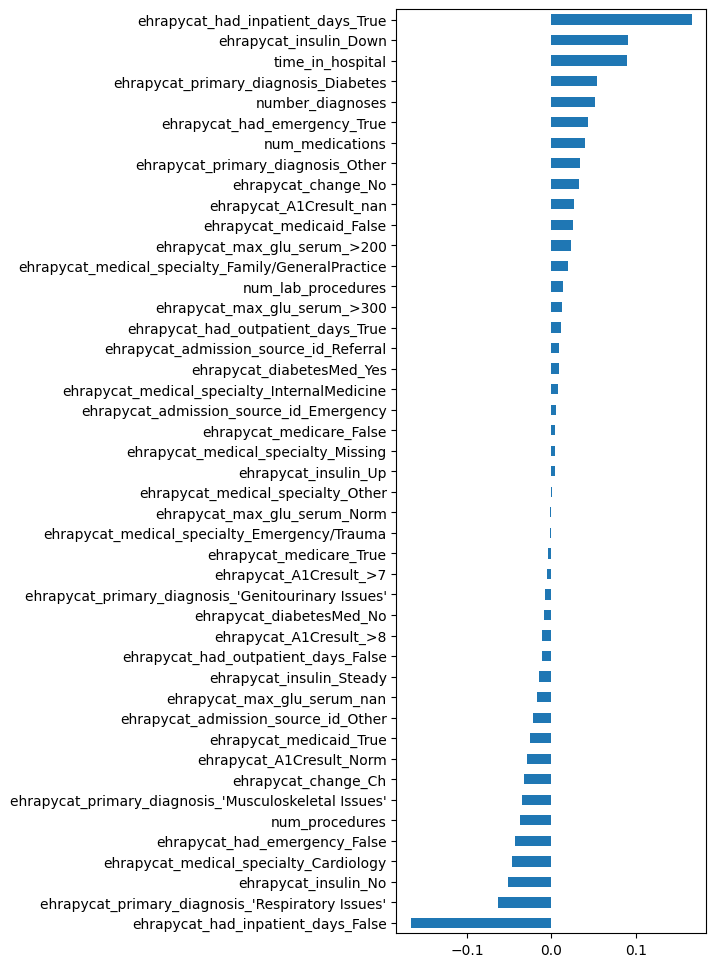

In [40]:
coef_series = pd.Series(
    data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0],
    index=X.columns,
)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

To check our model performance on the test data, we first look at the ROC curve of this binary classifier:

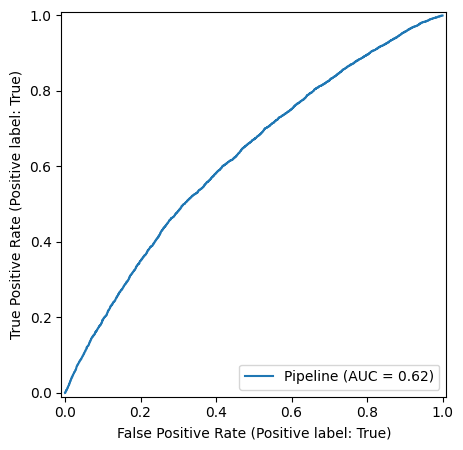

In [41]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:, 1]
Y_pred = unmitigated_pipeline.predict(X_test)

RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test, Y_test.astype(bool));

We observe an overall balanced accuracy of 0.59, well about random chance, albeit showing that the simplified model and assumptions are far from a reliable prediction.

In [42]:
balanced_accuracy_score(Y_test.astype(bool), Y_pred.astype(bool))

Using fairlearn's MetricFrame utility, we can conveniently inspect our target model performance measurements:

In [43]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

mf1 = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:385: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = data.groupby(all_grouping_names).apply(


,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.402554,0.434343,0.591948
Caucasian,0.381984,0.459930,0.589132
Other,0.325614,0.500000,0.596395
Unknown,0.246824,0.638554,0.561979


A barplot represents this information graphically:

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

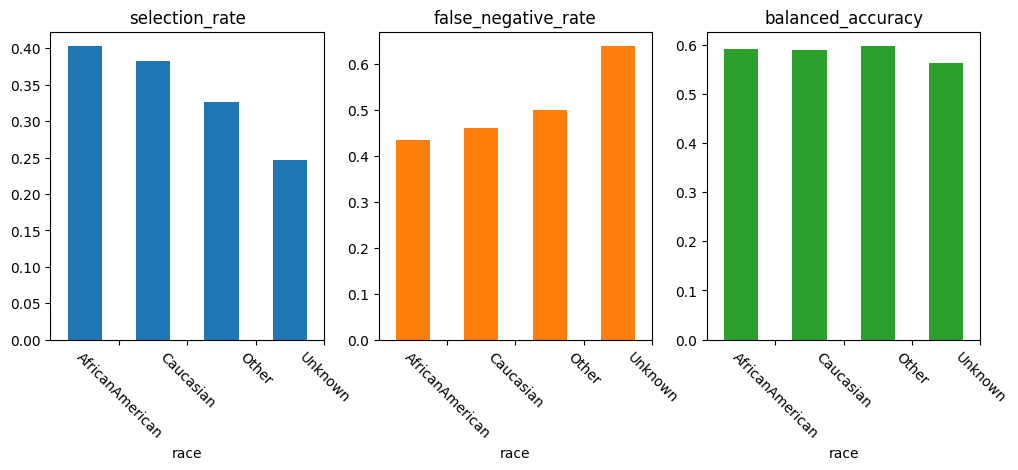

In [44]:
mf1.by_group.plot.bar(
    subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
)

We can observe that performance is worst for the "Other" and "Unkown" subgroups across all metrics.
Particularly relevant with respect to fairlearn's conception of fairness as harming a subgroup, the low selection rate and the worse False Negative rate in this smaller subgroups is highly relevant:

The model is biased towards a worse performance of these groups.

#### Mitigation: fairlearns ThresholdOptimizer

fairlearn's ThresholdOptimizer

In [45]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator

postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
)
postprocess_est.fit(
    X_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced
)
Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test,
)
pd.concat(
    [mf1.by_group, metricframe_postprocess.by_group],
    keys=["Unmitigated", "ThresholdOptimizer"],
    axis=1,
)

/Users/eljasroellin/Documents/ehrapy_clean/ehrapy_venv_march_II/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:385: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp = data.groupby(all_grouping_names).apply(


Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican       0.402554            0.434343          0.591948   
Caucasian             0.381984            0.459930          0.589132   
Other                 0.325614            0.500000          0.596395   
Unknown               0.246824            0.638554          0.561979   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican           0.325096            0.524334          0.584883  
Caucasian                 0.350669            0.486411          0.591857  
Other                     0.328922            0.485149          0.602776  
Unknown                   0.364791            0.542169          0.550309

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

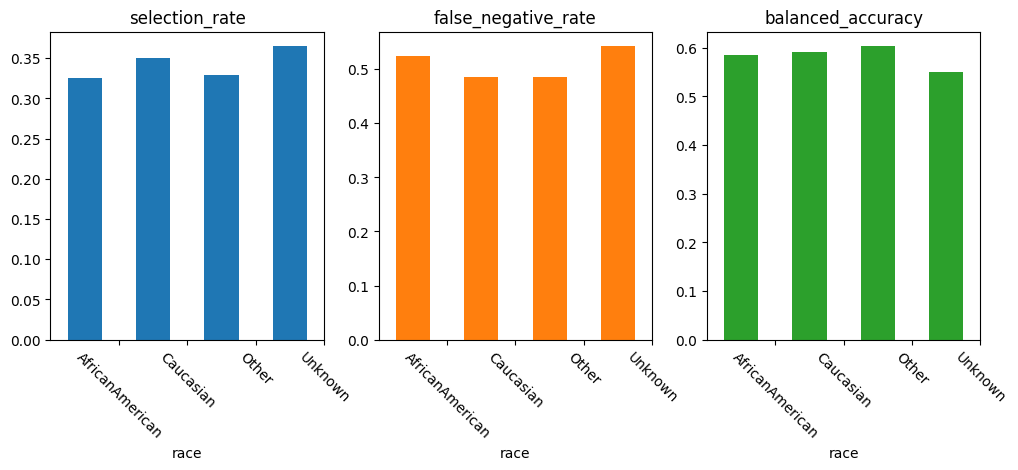

In [46]:
metricframe_postprocess.by_group.plot.bar(
    subplots=True, layout=[1, 3], figsize=(12, 4), legend=False, rot=-45, position=1.5
)
# postprocess_performance = figure_to_base64str(plt)

TODO
- write nice comments
- That performance can increase for others
- 

## Information bias

Information bias refers to inaccuracies or inconsistencies in the data recorded, which can stem from errors in how health information is documented, interpreted, or coded.
Such biases can lead to misclassifications, either overestimating or underestimating the association between exposures and outcomes.
For instance, if a condition is under-documented due to lack of standardized diagnostic criteria across EHR systems, studies might underestimate its prevalence and the effectiveness of treatments.

Just classical quality control. Show that there might be one group that is more susceptible to data information collection biases. Maybe show that some minority gets data measured with some cheap ass bad instrument that records mistakes, whereas rich people get the perfect new machine.


## Coding bias

Coding bias in EHR data arises when there are discrepancies or inconsistencies in how medical conditions, procedures, and outcomes are coded, often due to variation in the understanding and application of coding systems by different healthcare providers.
This can lead to misrepresentation of patient conditions, treatments received, and outcomes, affecting the reliability of research and analyses conducted using this data.
For example, two providers may code the same symptom differently, leading to challenges in accurately aggregating and comparing data across EHR systems.

Need to find some overlap in ICD encodings that can lead to this issue? Maybe consider showing that Mondo is great but simplifies some things that can lead to biases.

## Attrition bias

Attrition bias emerges when there is a systematic difference between participants who continue to be followed up within the healthcare system and those who are lost to follow-up or withdraw from the system.
This can lead to skewed outcomes or distorted associations in longitudinal studies, as the data may no longer be representative of the original population.
For example, if patients with more severe conditions are more likely to remain engaged in the healthcare system for ongoing treatment, studies may overestimate the prevalence of these conditions and their associated healthcare outcomes.

Find a way to get statistics on this and plot it.

## Confounding bias

Confounding bias arises when an outside variable, not accounted for in the analysis, influences both the exposure of interest and the outcome, leading to a spurious association between them.
This can distort the true effect of the exposure on the outcome, either exaggerating or underestimating it.
For example, if a study investigating the effect of a medication on disease progression fails to account for the severity of illness at baseline, any observed effect might be due more to the initial health status of the patient than to the medication itself.

Have a domain expert that helps with that -> try to get as much information about the data collection as possible.
Or try to find some correlations -> TBD.

## Normalization bias

Normalization biases arise when the methods used to standardize or normalize data across different scales or distributions inadvertently distort the underlying relationships or magnitudes in the data.
This can occur if the normalization technique does not account for intrinsic variability within subgroups or assumes a uniform distribution where it does not exist, leading to misleading interpretations of the data's true structure.
For example, applying the same normalization method to clinical measurements that vary widely between demographic groups (e.g., pediatric vs. adult populations) can mask important physiological differences and affect the accuracy of subsequent analyses.

1. Show how the distribution of some demographics and some actual measurement values -> show that they follow different distributions
2. Show somehow how normalizing them with the same method jointly isn't necessarily the smartest idea
3. Show that ehrapy normalization functions can be applied per column.
4. Show that ehrapy keeps the original values in `originals`

### Discussion and Conclusion

Datasets of Electronic Health Records are snapshots with limited information and typically contain multiple biases. To leverage the data available, it is important to describe and discuss such limitations. The combination of ehrapy and fairlearn helps in doing so in a reproducible, transparent manner.

Although we can use a variety of software tools to help us, biases and fairness is a sociotechnical challenge, so mitigations cannot be purely technical. These challenges needd to be supported by processes and practices, including government regulation and organizational incentives.